# Optimal Hedging in the Presence of Signals with Different Forecast Horizon

Assume we that $S$ is an asset price and that we observe two signals $f^1$ and $f^2$ with floating forecast horzions $x_2\gg x_1>0$.
Essentially, we will assume that
$$
f^i_t = \mathrm{E}_t\left[ S_{t+x^i} - S_t  \right] + \epsilon^{x^i}
$$
We model this scenario as follows: let $W, B^1, B^2$ be Brownian motions. We will assume that 
$$
\begin{array}{lll}
    dS_t & = & \sigma \left( \hat \rho_1 dW_t + \rho_1 \left( \rho_2 dB^1_t + \hat \rho_2 dB^2_t \right) \right) \\
    & = &  \sigma \left( \hat \rho_1 dW_t + r_1 dB^1_t + r_2 dB^2_t \right)
\end{array}
$$
with $\hat \rho := \sqrt{1 - \rho^2}$. The process has no drift. Adding drift does not add anything to the investigation at hand.
To model our signals, we assume that they have essentially visibility on a part of the future levels of the stock price via the property
$$
    f^i_t := \mathrm{E}_t\left[ S_{t+x^i} - S_t \big| B^i_{t+x^i} \right] = \mu\,x^i + \sigma r_i (B^i_{t+x^i} - B^i_t)
$$
That means the covariances between the signal and the stock return $S_{t+x^i} - S_t$ are given as
$$
\begin{array}{lll}
    r^2_1 & = & \frac{ \sigma^2 \rho_1^2 \rho_2^2 x_1  }{ \sigma^2 x_1 } = \rho_1^2\rho_2^2  \\
    r^2_2 & = & \frac{ \sigma^2 \rho_1^2 \hat \rho_2^2 x_1  }{ \sigma^2 x_1 } = \rho_1^2 (1 - \rho_2^2 )
\end{array}
$$
This allows us to control the $R^2$ of the signals in our setup. 


## Portfolio construction

We trade $a_t$ shares at any time $t$ subject to transaction cost $c(a_t)$. We model trading restrictions as inifinite cost. The trading decision is itself a neural network for the prevailing state, which in particular means the features $f$ here, i.e. $a_t \equiv a(\theta;f_t)$ with network weights $\theta$. We refer to the mark-to-market PnL up to a given point $T$ as:
$$
   \Pi_{T}(a) := \sum_{t\leq T} \delta_t dS_t - c(a_t)
$$
We will then optimize for a given concave utility $u$ the Deep Hedging problem
$$
    U(a) = \sup_{a,y}:\ \mathrm{E}\left[ u\left( \Pi_{T}(a) - y \right) + y\right] \ \ \ 
$$
If $\Pi(a)$ where normal, and if $u$ is the exponential utility, then this would reduce to solving the mean-variance problem for the optimal trading strategy. In this sense this is a generalized form of the Algre-Chris trading problem with temporary impact cost (permanent impact can easily be incorporated).

However: we may write this equivalently as
$$
   \Pi_{T}(a) := \sum_{t\leq T} a_t (S_T - S_t) - c(a_t) .
$$
Therefore, $\Pi$ is not normal even if $a_t = W f_t$ is a linear function of the features. Therefore, a mean-variance approach is unlikely to lead to a closed form solution for solving the optimal investment problem






In [1]:
%matplotlib inline
%autosave 60
import tensorflow as tf
from cdxbasics.config import Config, Int, Float
from cdxbasics.prettydict import PrettyOrderedDict as pdct
from cdxbasics.dynaplot import figure, colors_base
import numpy as np
import math as math
from IPython.display import display, Markdown

if False:
    import multiprocessing
    import ray
    from ray.util.queue import Queue
    import asyncio
    ray.shutdown()
    ray.init(num_cpus = 4) # Specify this system has 4 CPUs.

dtype = tf.float32
display(Markdown("## TensorFlow Signal Prediction"))
#display(Markdown("TensorFlow V%s, Ray V%s with %s nodes" % (tf.__version__, ray.__version__, multiprocessing.cpu_count() )))

Autosaving every 60 seconds


## TensorFlow Signal Prediction

In [2]:
"""
Tensorflow AMC Pricer as function of Neural Networks
"""

import importlib as imp

import deephedging.model_base as _
imp.reload(_)

from deephedging.model_base import Model, ProgressData, Environment, train, Context

def dense_model( nInput, nOutput, config = Config(), dtype=dtype, name=None, def_width = 50, def_depth = 3, def_activation = "relu", trainable=True ):
    """ Create simple dense model """
    width      = config("width", def_width, Int>0, "Width")
    depth      = config("depth", def_depth, Int>0, "Depth")
    activation = config("activation", def_activation, str, "Activation function")
    zero_model = config("zero_model", True, bool, "Whether to initialze levels (but not derivatives) of the model with zero")
    regression = config("simple_regression", False, bool, "Learn simple regression model only")
    inp_regrs  = config("input_regression", False, bool, "Inputs are regressed")
    config.done()

    if regression:
        depth      = 0
        width      = nInput
    
    def dense(width,activation, x1, x2 ):
        d1 = tf.keras.layers.Dense(units=width,
                                   activation=activation,
                                   use_bias=True, dtype=dtype,
                                   trainable=True )
        if x2 is None:
            return d1(x1), None

        d2 = tf.keras.layers.Dense(units=width,
                                   activation=activation,
                                   use_bias=True, dtype=dtype,
                                   trainable=False )
        x1 = d1(x1)
        x2 = d2(x2)
        return x1, x2
    
    inp       = tf.keras.layers.Input( shape=(nInput,), dtype=dtype )    
    x1, x2    = ( inp, inp if zero_model else None )
    if inp_regrs:
        x1, x2 = dense( 1, "linear", x1, x2 )
    for d in range(depth):
        x1, x2    = dense( width, activation, x1, x2 )
    x1, x2 = dense( nOutput, "linear", x1, x2 ) 
    x  = tf.keras.layers.Subtract()([x1, x2]) if not x2 is None else x1
    m  = tf.keras.Model( inputs=inp, outputs=x, name=name )
    if zero_model:
        for v1, v2 in zip( m.trainable_weights, m.non_trainable_weights ):
            v2.assign( v1.value() )        
    return m

@tf.function
def clip( x : tf.Tensor, minx : tf.Tensor, maxx : tf.Tensor ) -> tf.Tensor:
    """ Clip 'x' within the allowed trading range """
    #with tf.control_dependencies( [ tf.debugging.assert_greater_equal( maxx, minx, message="Upper bound for trades must be bigger than lower bound" ) ] ):
    x_ = tf.where( maxx > minx, tf.clip_by_value( x, minx, maxx ), 0.5*(maxx+minx) )
    p  = tf.math.abs( x - x_ ) ** 2
    return x_, p
    """
    
        p1 = tf.maximum( x - maxx, 0. )
        p2 = tf.maximum( minx - x, 0. )
        x  = tf.maximum( minx, tf.minimum( maxx, x ) )
        
        dx  = maxx - minx
        dx  = tf.where( dx < 1E-8, 0., dx )
        dx_ = tf.where( dx < 1E-8, 1., dx )  # avoid dividing by zero
        x   = (x - minx) / dx_ 
        x   = tf.math.sigmoid( x )
        return minx + x * dx
    """
    
@tf.function  
def tf_utility( utility : str, lmbda : float, X : tf.Tensor, y : tf.Tensor = 0. ) -> tf.Tensor:
    """ From https://github.com/hansbuehler/deephedging/blob/main/objectives.py """
    utility  = str(utility)
    lmbda    = float(lmbda)
    X        = tf.debugging.check_numerics(X, "Numerical error input X")
    y        = y if not y is None else 0.
    gains    = X + y    
    assert lmbda >= 0., "Risk aversion 'lmbda' cannot be negative. Found %g" % lmbda
    if utility in ["mean", "expectation"] or lmbda <= 1E-12:
        # Expectation
        u = gains        
    elif utility == "cvar":
        u = (1.+lmbda) * tf.math.minimum( 0., gains ) - y
    elif utility == "quad":
        x0 = 1./lmbda
        xx = tf.minimum( 0., gains-x0 )
        u  = - 0.5 * lmbda * (xx**2) + 0.5 * lmbda * (x0**2) - y
    elif utility in ["exp", "entropy"]: 
        inf = tf.stop_gradient( tf.reduce_min( X ) )
        u = (1. - tf.math.exp( - lmbda * (gains-inf)) ) / lmbda - y + inf        
    elif utility == "exp2":
        g1  = tf.maximum(gains,0.)
        g2  = tf.minimum(gains,0.)
        eg1 = tf.math.exp( - lmbda * g1)
        u1  = (1. - eg1 ) / lmbda - y            
        u2  = g2 - 0.5 * lmbda * g2 * g2 - y
        u   = tf.where( gains > 0., u1, u2 )        
    elif utility == "vicky":
        u = (1. + lmbda * gains - tf.math.sqrt( 1. + (lmbda * gains) ** 2 )) / lmbda  - y
    assert not u is None, "Unknown utility function '%s'." % utility
    u = tf.debugging.check_numerics(u, "Numerical error computing u")
    return u

class SignalModel( Model ):
    
    def __init__(self, config = Config() ):
        Model.__init__(self, cache_uid=config, dtype=dtype, name="SignalModel")
        self.utility             = config("utility", "exp", str, "Utility function")
        self.lmbda               = config("lmbda", 1., Float>=0., "Risk aversion")
        self.nStates             = config("states", 2, Int>=0, "Number of recurrent states")
        self.states_01           = config("states_01", True, bool, "Whether to restrict states to (-1,+1)")
        self.max_delta           = config("max_delta",  1., Float>=0., "Maximum delta, in units")
        self.min_delta           = config("min_delta", -1., Float<=0., "Minimum delta, in units")
        self.max_delta_cash      = config("max_delta_cash",  10., Float>=0., "Maximum delta, in $")
        self.min_delta_cash      = config("min_delta_cash", -10., Float<=0., help="Minimum delta, in $")
        self.max_trade           = config("max_trade",  10., Float>=0., "Maximum trade per time step, in units")
        self.min_trade           = config("min_trade", -10., Float<=0., "Minimum trade per time step, in units")
        self.abs_cost            = config("abs_cost",   0.0002, Float>=0, "Absolute trading cost")
        self.pow_cost            = config("pow_cost",   0., Float>=0, "Trading cost for power cost")
        self.cost_power          = config("cost_power", 1.5, Float>=1., "Which power to use for cost. Cost are a function of the $ size of the trade, and need to be convex.")
        self.config_network      = config.network.detach()
        self.config_init_network = config.init_network.detach()
        self.config_y_network    = config.y_network.detach()
        self.nFeatures           = None
        config.done()
            
    def build(self, shapes):
        """ build the network """
        spots            = shapes['spots']
        features         = shapes['features']
        nSteps           = int(spots[1])
        nFeatures        = int(features[2])
        self.nFeatures   = nFeatures
        self.input_names = [ ('S%ld' % i) for i in range(nFeatures) ] + ['trade','delta'] + [ ('state%ld' % i) for i in range(self.nStates) ]        
        nInput           = 2 + self.nStates + nFeatures   # delta, action, states, features
        nOutput          = self.nStates*2 + 1
        self.trade_model = dense_model( nInput, nOutput, self.config_network, dtype=self.dtype, name="TradeModel" )
        self.init_model  = dense_model( nFeatures, self.nStates, self.config_init_network, dtype=self.dtype, name="InitStateModel", def_width = 10, def_depth = 3, def_activation = "relu"  )
        self.y_model     = dense_model( nFeatures, 1, self.config_y_network, dtype=self.dtype, name="yStateModel", def_width = 10, def_depth = 3, def_activation = "relu"  )

    def call(self, data, training=False):
        """ Execute core Monte Carlo """      
        spots     = data['spots']
        features  = data['features']
        nBatch    = spots.shape[0]
        nSteps    = int( spots.shape[1] )
        nFeatures = int( features.shape[2] )

        trade     = tf.zeros_like(spots[:,0])
        delta     = tf.zeros_like(trade)
        pnl       = tf.zeros_like(trade)
        penalty   = tf.zeros_like(trade)
        states    = self.init_model( features[:,0,:], training=training )
        states    = tf.math.tanh( states ) if self.states_01 else states
        recinputs = tf.zeros_like(trade)[:,tf.newaxis,tf.newaxis]
        trades    = tf.zeros_like(trade)[:,tf.newaxis]
        costs     = tf.zeros_like(trade)[:,tf.newaxis]
        pnls      = tf.zeros_like(trade)[:,tf.newaxis]
        t         = 0

        while tf.less(t,nSteps-1):
            tf.autograph.experimental.set_loop_options( shape_invariants=[\
                                                                    (costs, tf.TensorShape([None,None])), \
                                                                    (trades, tf.TensorShape([None,None])),\
                                                                    (pnls, tf.TensorShape([None,None])),\
                                                                    (recinputs, tf.TensorShape([None,None,None]))] )

            # call model
            inputs    =  [ features[:,t,:], trade, delta, states ]   # WARNING: keep features first in this list !
            inputs    =  tf.concat( [ (f[:,tf.newaxis] if len(f.shape) == 1 else f) for f in inputs ], axis=1 )
            action    =  self.trade_model( inputs, training=training )
            assert action.shape[1] == self.nStates*2 + 1, (action.shape[1], self.nStates*2 + 1)
            trade     =  action[:,-1] 
            max_delta =  tf.minimum( self.max_delta, self.max_delta_cash / spots[:,t] )       # delta+trade <= max_delta
            max_trade =  tf.minimum( self.max_trade,  max_delta - delta ) 
            min_delta =  tf.maximum( self.min_delta, self.min_delta_cash / spots[:,t] )  
            min_trade =  tf.maximum( self.min_trade, min_delta - delta ) 
            trade, p  =  clip( trade, min_trade, max_trade )
            delta     += trade
            
            # various ways to interpret the signal
            absprice  =  tf.math.abs( spots[:,t] * trade )
            cost      =  self.abs_cost * absprice + self.pow_cost * tf.math.pow( absprice, self.cost_power )
            dS        =  spots[:,t+1] - spots[:,t]
            pnl       += delta * dS - cost
            
            # penalty
            penalty   += p

            # exponential state update
            nstates   = action[:,:self.nStates]
            nstates   = tf.math.tanh( nstates ) if self.states_01 else nstates
            update    = action[:,self.nStates:2*self.nStates]
            update    = tf.math.sigmoid( update )
            states    = update * nstates + (1. - update) * states

            # loop
            costs     = tf.concat( [ costs, cost[:,tf.newaxis] ], axis=1 ) if t > 0 else cost[:,tf.newaxis]
            trades    = tf.concat( [ trades, trade[:,tf.newaxis] ], axis=1 ) if t > 0 else trade[:,tf.newaxis]
            pnls      = tf.concat( [ pnls, pnl[:,tf.newaxis] ], axis=1 ) if t > 0 else pnl[:,tf.newaxis]
            recinputs = tf.concat( [ recinputs, inputs[:,tf.newaxis,:] ], axis = 1 ) if t > 0 else inputs[:,tf.newaxis,:]
            t         = t+1

        # liquidiate
        absprice =  tf.math.abs( spots[:,-1] * delta )
        cost     =  self.abs_cost * absprice + self.pow_cost * tf.math.pow( absprice, self.cost_power )
        pnl      -= cost
        costs    =  tf.concat( [ costs, cost[:,tf.newaxis] ], axis=1 ) if nSteps > 0 else cost[:,tf.newaxis]
        pnls     =  tf.concat( [ pnls, pnl[:,tf.newaxis] ], axis=1 )
        trades   =  tf.concat( [ trades, -delta[:,tf.newaxis] ], axis=1 ) if nSteps > 0 else trade[:,tf.newaxis]
        
        # OCE
        y        =  self.y_model( features[:,0,:], training=training )[:,0]
        utility  =  tf_utility( self.utility, self.lmbda, X=pnl, y=y )
        loss     =  - utility + penalty
        
        return dict( loss=loss,
                     utility=utility,
                     penalty=penalty,
                     pnl=pnl,
                     pnls=pnls,
                     trades=trades,
                     recinputs=recinputs)

print("/Done")

Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs
/Done


## Visualize Market

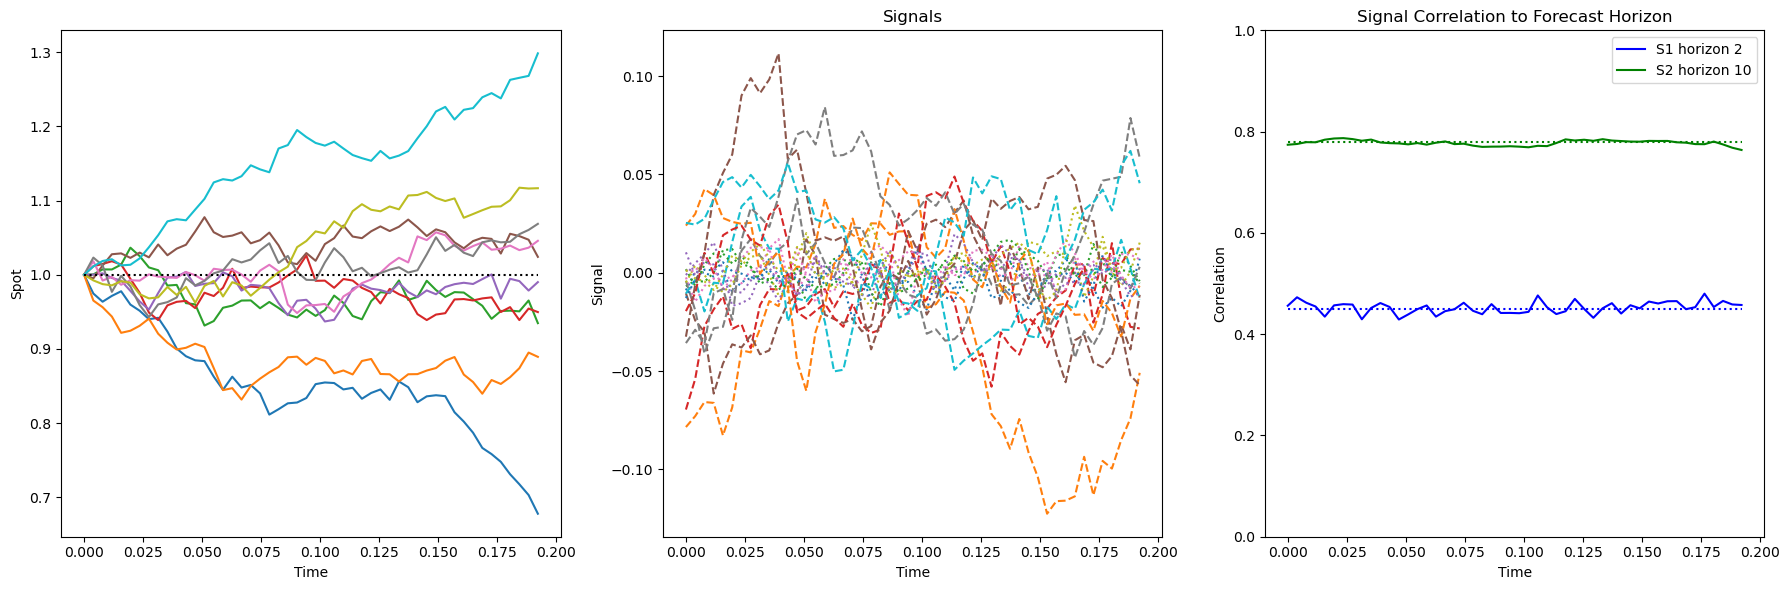

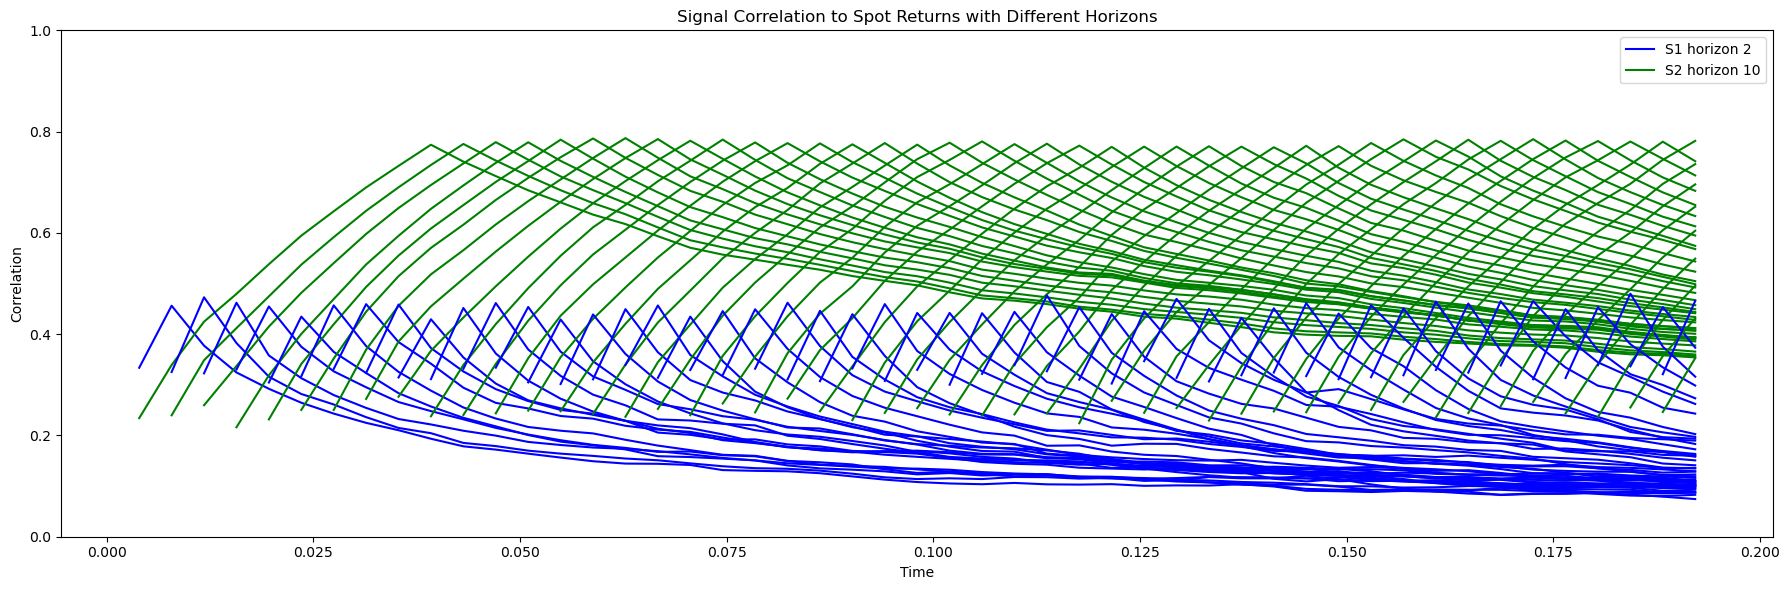

In [3]:
"""
Simple Black & Scholes Market Simulator with two correlated forward looking signals 
"""

# generate path
rho1      = 0.9
rho2      = 0.5
vol       = 0.2
drift     = 0.0
dt        = 1./255.
nSteps    = 50
nH1       = 2
nH2       = 10
nSamples  = 5000
nEffSteps = nSteps+nH2 

hatrho1  = math.sqrt( 1. - rho1**2 )
hatrho2  = math.sqrt( 1. - rho2**2 )
r1       = rho1 * rho2
r2       = rho1 * hatrho2
r0       = hatrho1
dB       = np.random.normal( size=(nSamples, nEffSteps-1,3) ) * math.sqrt(dt)
dB       -= np.mean( dB, axis=0 )[np.newaxis,:,:]
dW       = r0 * dB[:,:,0] + r1 * dB[:,:,1] + r2 * dB[:,:,2]
dS       = drift * dt + vol * dW
dS1      = drift * dt + vol * r1 * dB[:,:,1]
dS2      = drift * dt + vol * r2 * dB[:,:,2]

S        = np.ones((nSamples,nEffSteps))
S1       = np.ones((nSamples,nEffSteps))
S2       = np.ones((nSamples,nEffSteps))
S[:,1:]  += np.cumsum( dS, axis=1 )
S1[:,1:] += np.cumsum( dS1, axis=1 )
S2[:,1:] += np.cumsum( dS2, axis=1 )
times    = np.linspace(0,nEffSteps-1,nEffSteps) * dt
ixs      = np.argsort(S[:,nSteps])
S        = S[ixs,:]
S1       = S1[ixs,:]
S2       = S2[ixs,:]

spots    = S[:,:nSteps]
times    = times[:nSteps]
f        = np.zeros((nSamples,nSteps,2))
f[:,:,0] = S1[:,nH1:nH1+nSteps] - S1[:,:nSteps]
f[:,:,1] = S2[:,nH2:nH2+nSteps] - S2[:,:nSteps]

tf_data    = dict( spots = tf.convert_to_tensor( spots, dtype=dtype),
                   features = tf.convert_to_tensor( f, dtype=dtype) )

# -------- visualize -----------

display(Markdown("## Visualize Market"))

fig = figure(col_size=6, row_size=6)
ax  = fig.add_subplot()
ax_  = fig.add_subplot()
ax_.set_title("Signals")

npl = 10
idx = np.linspace(0,nSamples-1,npl,endpoint=True,dtype=np.int32)
for i in idx:
    ax.plot(  times, spots[i,:] )
    ax_.plot( times, f[i,:,0], ":" )
    ax_.plot( times, f[i,:,1], "--" )
ax.plot( times, np.mean( spots, axis=0 ), ":", color="black" )
ax.set_xlabel("Time")
ax.set_ylabel("Spot")
ax_.set_xlabel("Time")
ax_.set_ylabel("Signal")

# correlation between signal and forecast horizon
corr1 = []
corr2 = []
for t in range(nSteps):
    dS_1 = S[:,t+nH1] - S[:,t]
    dS_2 = S[:,t+nH2] - S[:,t]
    
    c1 = np.corrcoef( [dS_1, f[:,t,0]] )
    c2 = np.corrcoef( [dS_2, f[:,t,1]] )
    corr1.append( c1[0,1] )
    corr2.append( c2[0,1] )

ax_corr  = fig.add_subplot()
ax_corr.set_title("Signal Correlation to Forecast Horizon")
ax_corr.set_ylim(0.,+1.)
ax_corr.set_xlabel("Time")
ax_corr.set_ylabel("Correlation")
colors = colors_base()
color  = next(colors)
ax_corr.plot( times, corr1, color=color, label="S1 horizon %ld" % nH1)
ax_corr.plot( times, times*0. + rho1*rho2,":", color=color )
color  = next(colors)
ax_corr.plot( times, corr2, color=color, label="S2 horizon %ld" % nH2)
ax_corr.plot( times, times*0. + rho1*math.sqrt(1.-rho2**2), ":", color=color )
ax_corr.legend()
fig.render()
fig.close()

# correlation between signal and spot returns
fig = figure(col_nums=1, col_size=18, row_size=6)
ax_corr  = fig.add_subplot()
ax_corr.set_title("Signal Correlation to Spot Returns with Different Horizons")
ax_corr.set_ylim(0.,+1.)
ax_corr.set_xlabel("Time")
ax_corr.set_ylabel("Correlation")
for t in range(nSteps):
    corr1 = []
    corr2 = []    
    for s in range(t+1,nSteps):
        dS = S[:,s] - S[:,t]    
        c1 = np.corrcoef( [dS, f[:,t,0]] )
        c2 = np.corrcoef( [dS, f[:,t,1]] )
        corr1.append( c1[0,1] )
        corr2.append( c2[0,1] )

    colors = colors_base()
    color  = next(colors)
    ax_corr.plot( times[t+1:], corr1, color=color, label=("S1 horizon %ld" % nH1) if t==0 else None)
    color  = next(colors)
    ax_corr.plot( times[t+1:], corr2, color=color, label=("S2 horizon %ld" % nH2) if t==0 else None)
ax_corr.legend()

fig.render()
fig.close()



## Regression

01:   Training loop starting
01:   Model evaluated with current weights. Model has 8 weights.


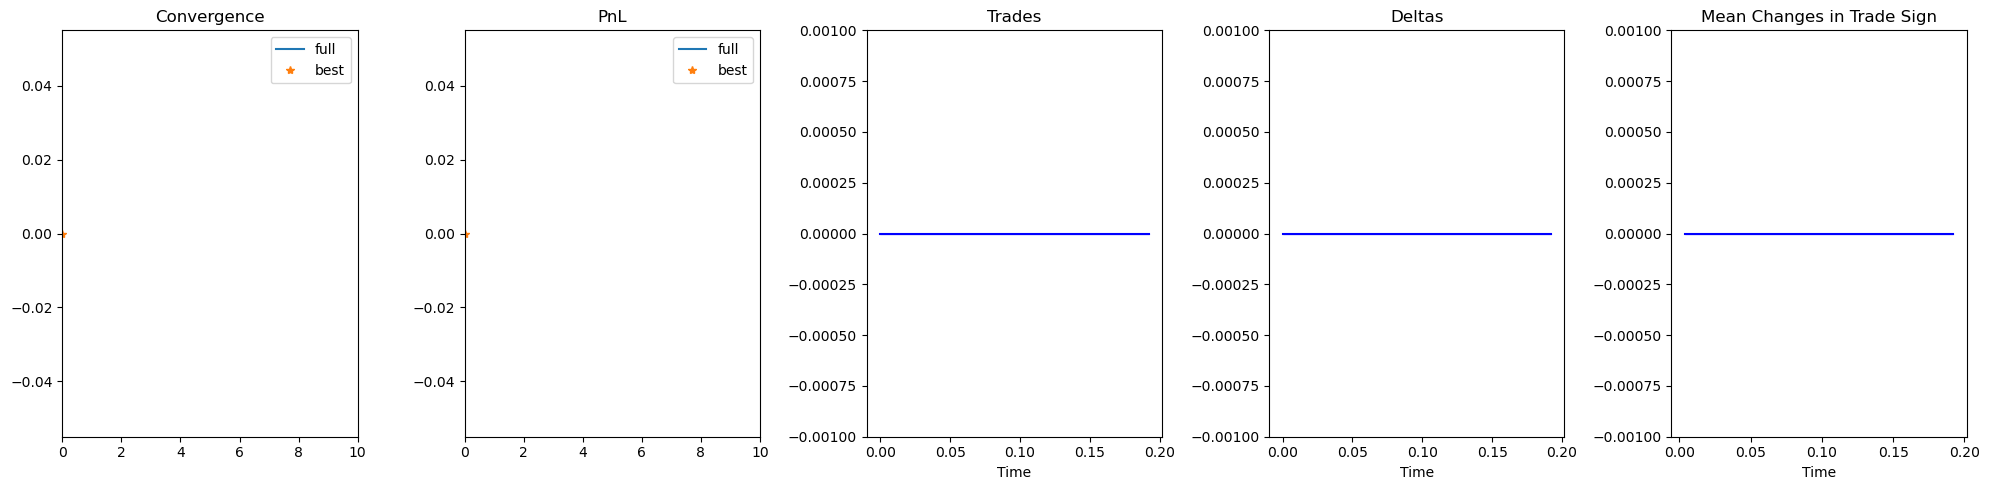

02:     Caching enabled @ 'C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.cache/SignalModel_/8d92df70e58e75117c00dffbad4657bb.pck'
03:       Cache successfully loaded. Current epoch: 10
02:     Nothing to do: cached model loaded from C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.cache/SignalModel_/8d92df70e58e75117c00dffbad4657bb.pck was trained for 10 epochs; you have asked to train for 10 epochs.
02:     If you want to force training: raise number of epochs or turn off caching.
02:     Status: Model was already trained for at least 10 epochs.
02:     Weights set to best epoch: 10
02:      State of training until epoch 10 cached into C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.cache/SignalModel_/8d92df70e58e75117c00dffbad4657bb.pck
02:      Time: 2023-03-02 08:58:43
01:   Training completed. Total training took 6s


## Signal Regression

01:   Training loop starting
01:   Model evaluated with current weights. Model has 15 weights.


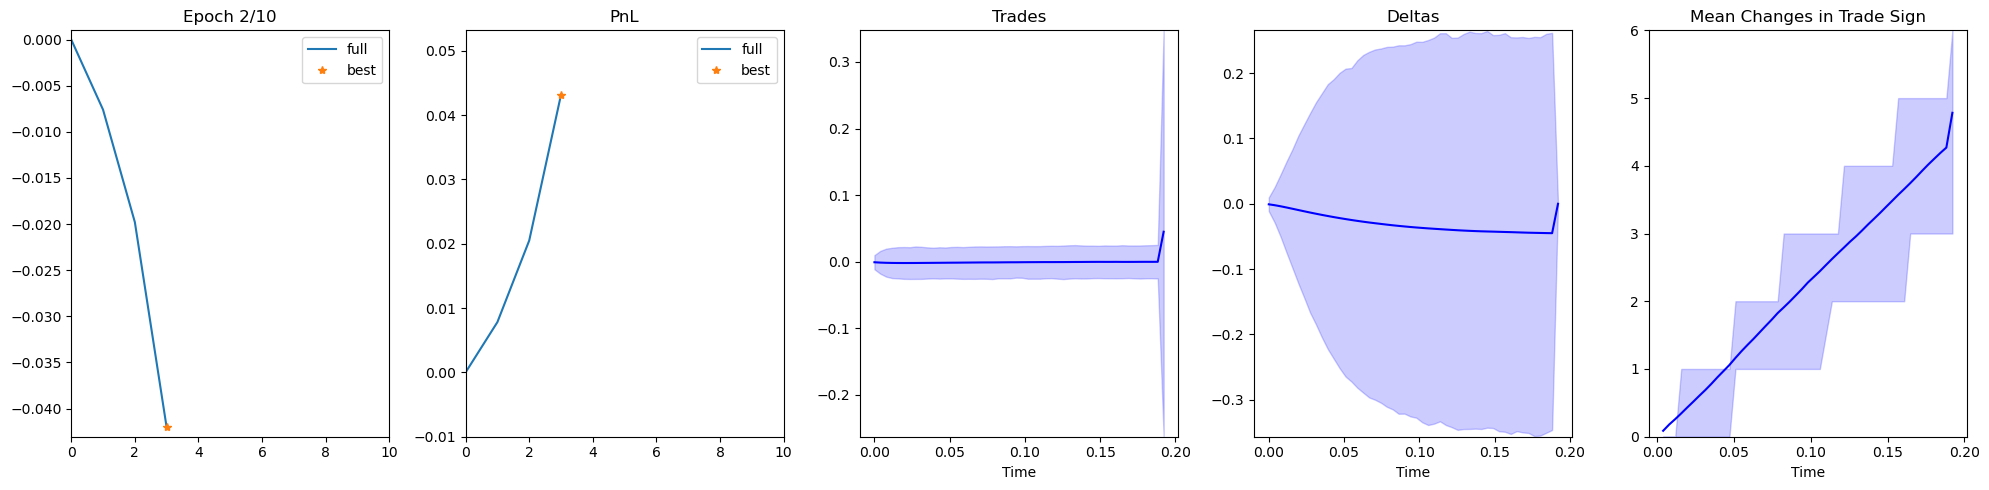

02:     Caching enabled @ 'C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.cache/SignalModel_/5c7a756d12d5713d42c6a7b93a22e77b.pck'


In [ ]:
"""
Mini training to test it all works
"""

def default_loss(y_true,y_pred):
    """ Just minimize expected loss """
    return y_pred

class Percentile_plot( object ):
    
    def __init__(self, ax, x, y, color, alpha=0.2, dyeps = 0.001, **kwargs ):
        assert len(x) == y.shape[1], (len(x), y.shape)
        self.ax      = ax
        self.x       = x
        self.color   = color
        self.alpha   = alpha
        self.dyeps   = dyeps
        m,u,d,mi,mx  = self.calc( y )
        self.ln      = ax.plot( x, m, color=color, **kwargs )[0]
        self.fl      = ax.fill_between( x, d, u, color=color, alpha=alpha )
        ax.set_ylim( mi-dyeps, mx+dyeps )
        
    def calc(self, y):
        mean = np.mean(y,axis=0)
        up   = np.percentile(y,75,axis=0)
        dn   = np.percentile(y,25,axis=0)
        mx   = np.max( up )
        mi   = np.min( dn )        
        return mean, up, dn, mi, mx
        
    def update(self, y ):
        assert len(self.x) == y.shape[1], (len(self.x), y.shape)
        m,u,d,mi,mx  = self.calc( y )
        self.ln.set_ydata( m )
        self.fl.remove()
        self.fl = self.ax.fill_between( self.x, d, u, color=self.color, alpha=self.alpha )
        self.ax.set_ylim( mi-self.dyeps, mx+self.dyeps )

class Plotter( object ):

    def init(self, progress, model, r0, training_info ):
        self.fig          = figure()
        # progress
        self.ax_prg = self.fig.add_subplot()
        self.ax_prg.set_title("Convergence")
        self.ln_prg = self.ax_prg.plot( [0], progress.losses, label="full" )[0]
        self.ln_bst = self.ax_prg.plot( [0], [progress.best_loss], "*", label="best" )[0]
        self.ax_prg.legend()
        self.ax_prg.set_xlim( 0, training_info.epochs )
        
        # pnl
        self.ax_pnl = self.fig.add_subplot()
        self.ax_pnl.set_title("PnL")
        self.ln_pnl  = self.ax_pnl.plot( [0], progress.pnls, label="full" )[0]
        self.ln_bstP = self.ax_pnl.plot( [0], [progress.best_loss], "*", label="best" )[0]
        self.ax_pnl.legend()
        self.ax_pnl.set_xlim( 0, training_info.epochs )
        
        # trades
        trades        = np.array( r0['trades'] )
        self.ax_trade = self.fig.add_subplot()
        self.ax_trade.set_title("Trades")
        self.ax_trade.set_xlabel("Time")
        self.pp_trade = Percentile_plot( self.ax_trade, times, trades, color="blue" )
        self.ax_trade.plot( times, times*0.+model.min_trade, ":", color="black")
        self.ax_trade.plot( times, times*0.+model.max_trade, ":", color="black")        

        # deltas
        deltas        = np.cumsum(trades,axis=1)
        self.ax_delta = self.fig.add_subplot()
        self.ax_delta.set_title("Deltas")
        self.ax_delta.set_xlabel("Time")
        self.pp_delta = Percentile_plot( self.ax_delta, times, deltas, color="blue" )
        self.ax_delta.plot( times, times*0.+model.min_delta, ":", color="black")
        self.ax_delta.plot( times, times*0.+model.max_delta, ":", color="black")

        # changes of sign
        signed      = np.sign( trades )
        changes     = np.abs( signed[:,1:] - signed[:,:-1] ) / 2
        changes     = np.cumsum( changes, axis=1 )
        self.ax_changes = self.fig.add_subplot()
        self.ax_changes.set_title("Mean Changes in Trade Sign")
        self.ax_changes.set_xlabel("Time")
        self.pp_changes = Percentile_plot( self.ax_changes, times[1:], changes, color="blue" )

        self.fig.render()

    def update(self, progress, training_info, trades, deltas, changes ):
        
        self.ax_prg.set_title("Epoch %ld/%ld" % (progress.current_epoch,training_info.epochs))
        self.ln_prg.set_xdata( np.linspace(0,len(progress.losses)-1,len(progress.losses),dtype=np.int32) )
        self.ln_prg.set_ydata( progress.losses )
        self.ax_prg.set_ylim( min(progress.losses)-0.001, max(progress.losses)+0.001 )
        self.ln_pnl.set_xdata( np.linspace(0,len(progress.losses)-1,len(progress.losses),dtype=np.int32) )
        self.ln_pnl.set_ydata( progress.pnls )
        self.ax_pnl.set_ylim( min(progress.pnls)-0.01, max(progress.pnls)+0.01 )
        
        self.pp_trade.update( trades )
        self.pp_delta.update( deltas )
        self.pp_changes.update( changes )
        
        best_pnl  = progress.pnls[ progress.best_epoch+1 ]
        best_loss = progress.losses[ progress.best_epoch+1 ]

        self.ln_bst.set_xdata( [progress.best_epoch+1] )
        self.ln_bst.set_ydata( [best_loss] )
        self.ln_bstP.set_xdata( [progress.best_epoch+1] )
        self.ln_bstP.set_ydata( [best_pnl] )

        self.fig.render()        

plotter = Plotter()

class Progress( ProgressData ):
    
    def __init__(self, environment,
                       training_info,
                       config
                       ):        
        predicted_data0 = environment.predict()
        ProgressData.__init__( self, environment, training_info, predicted_data0 )

        r0                = predicted_data0.trn.results
        model             = environment.model
        self.losses       = [ np.mean( r0['loss']) ]
        self.pnls         = [ np.mean( r0['pnl']) ]
        self.update_freq  = config("update_freq", 1, Int>0, "Update frequency in epochs")
        config.done()
        
        plotter.init( self, model, r0, training_info )
        
    def on_epoch_end(self,  environment,
                            predicted_data,
                            training_info,
                            logs
                        ) -> int:        
        assert self.current_epoch+1 == len(self.losses), (self.current_epoch, len(self.losses))
        r           = predicted_data.trn.results
        model       = environment.model
        loss        = np.mean( r['loss'] )
        pnl         = np.mean( r['pnl'] )
        trades      = np.array( r['trades'] )
        deltas      = np.cumsum( trades, axis=1 )
        pnls        = np.array( r['pnls'] )
        signed      = np.sign( trades )
        changes     = np.abs( signed[:,1:] - signed[:,:-1] ) / 2
        changes     = np.cumsum( changes, axis=1 )
        self.losses.append( loss )
        self.pnls.append( pnl )

        plotter.update( self, training_info, trades, deltas, changes )
        return self.CONTINUE
    
    def on_done(self, environment,
                    predicted_data,
                    training_info,
                ):
        self.on_epoch_end( environment, predicted_data, training_info )

        

def make_pdct( x ):
    if isinstance(x, pdct):
        return x
    return pdct(x)

def my_train(config):
    environment = Environment( model       = SignalModel( config.model ), 
                               tf_trn_data = tf_data )
    r = train( environment = environment,
                  create_progress = Progress,
                  config = config,
                  verbose = Context(verbose="all"))
    
    return make_pdct(r)

                       

base_config     = Config()
base_config.train.epochs = 2
base_config.model.network.zero_model = True
base_config.model.abs_cost = 0.001 # 10bps
base_config.progress.update_freq = 5

config = base_config.copy()
config.model.network.simple_regression = True # hard overwrite for linear network configuration
config.model.init_network.simple_regression = True # hard overwrite for linear network configuration
config.model.y_network.simple_regression = True # hard overwrite for linear network configuration
config.train.epochs = 10
config.model.states   = 0

all_trained_data = pdct()
display(Markdown("## Regression"))
all_trained_data.regression = my_train( config )

all_trained_data = pdct()
config.model.states   = 0
config.model.network.input_regression = True
config.model.init_network.input_regression = True
config.model.y_network.input_regression = True
display(Markdown("## Signal Regression"))
all_trained_data.signal_regression = my_train( config )

config = base_config.copy()
config.model.states   = 0
display(Markdown("## No States"))
all_trained_data.states_0 = my_train(config )

config = base_config.copy()
config.model.states       = 2
display(Markdown("## Two States"))
all_trained_data.states_2 = my_train( config )

config = base_config.copy()
config.model.states       = 10
display(Markdown("## 10 states"))
all_trained_data.states_10 = my_train(config )

all_results = pdct()

for k in all_trained_data:
    all_results[k] = pdct( all_trained_data[k].trn.results )
    all_results[k].trade_model= all_trained_data[k].model.trade_model
    all_results[k].input_names = all_trained_data[k].model.input_names

print("/done")


## Performance

In [ ]:
nVisCol     = 3
nVisRow     = 1
paths       = np.random.choice( nSamples, size=(nVisCol*nVisRow,) )
all_cvars   = pdct()
pcntils     = np.linspace(10.,90.,9,endpoint=True)

fig = figure()
fig.suptitle("Aggregate Comparison Statistics", fontsize=16)

# CVaR PnL
ax = fig.add_subplot()
ax.set_title( "$CVaR^+$ PnL" )
ax.set_xlabel("Percentile")
ax.set_ylabel("Conditional PnL")
ax.set_xlim(-100,100)
colors = colors_base()

for k in all_results:
    results      = all_results[k]
    pnl          = results['pnl']
    percentiles  =  [ np.percentile( pnl, p ) for p in pcntils ]
    cvars        =    [ np.mean( pnl[ pnl<= p ] ) for p in percentiles ] \
                    + [ np.mean(pnl) ] \
                    + [ np.mean( pnl[ pnl> p ] ) for p in percentiles ]
    labels       = np.linspace(-90,90,19,endpoint=True)
    color        = next(colors)
    ax.plot( labels, cvars, label=k, color=color )
    ax.plot( labels, labels*0.+cvars[9], ":", color=color )
    ax.plot( [0], cvars[9], "8", color=color )

ax.legend()

# Turn over
ax = fig.add_subplot()
ax.set_title( "Turnover #units" )
ax.set_xlabel("Time")
ax.set_ylabel("Units")
ax2 = fig.add_subplot()
ax2.set_title( "Turnover $Cash" )
ax.set_xlabel("Time")
ax2.set_ylabel("Cash")
colors = colors_base()

for k in all_results:
    results      = all_results[k]
    color        = next(colors)
    trades       = results['trades']

    turnover     = np.cumsum( np.abs( trades ), axis=1 )
    m            = np.mean( turnover, axis=0 )
    up           = np.percentile( turnover,75,axis=0 )
    dn           = np.percentile( turnover,25,axis=0 )

    ax.plot( times, m, color=color, label=k+"#" )
    ax.fill_between( times, dn, up, color=color, alpha=0.1 )

    turnoverC    = np.cumsum( np.abs( trades*spots ), axis=1 )
    mC           = np.mean( turnoverC, axis=0 )
    upC          = np.percentile( turnoverC,75,axis=0 )
    dnC          = np.percentile( turnoverC,25,axis=0 )

    ax2.plot( times, mC, "--", color=color, label=k+"$" )
    ax2.fill_between( times, dnC, upC, color=color, alpha=0.1 )

ax.legend()
ax2.legend()

fig.render()
fig.close()

In [ ]:
# correlation between signal and spot returns
fig = figure()
fig_scat = figure()
offset  = max( nH1, nH2 )*2
T       = max( nH1, nH2 )*2
fig.suptitle("Trading Signal Correlation with Forward Returns\n(at fixed time step %ld)" % offset, fontsize=16)

axs = []
for k in all_results:
    results = all_results[k]
    trades  = results['trades']
    ax_corr = fig.add_subplot()
    axs.append( ax_corr )
    ax_corr.set_title(k)
    ax_corr.set_xlabel("Time")
    ax_corr.set_ylabel("Correlation")
    corr1 = []
    corr2 = []    
    f1    = f[:,offset,0]
    f2    = f[:,offset,1]
    for t in range(T):
        rt = spots[:,offset+t] - spots[:,offset]
        c1 = np.corrcoef( [rt, f1] )
        c2 = np.corrcoef( [rt, f2] )
        corr1.append( c1[0,1] )
        corr2.append( c2[0,1] )

    colors = colors_base()
    ax_corr.plot( times, times*0., ":", color="black")
    color  = next(colors)
    ax_corr.plot( times[t:t+T], corr1, color=color, label=("S1 horizon %ld" % nH1) )
    ax_corr.plot( [times[t+nH1]], [corr1[nH1]], "*", color=color )
    color  = next(colors)
    ax_corr.plot( times[t:t+T], corr2, color=color, label=("S2 horizon %ld" % nH2) )
    ax_corr.plot( [times[t+nH2]], [corr2[nH2]], "*", color=color )
    ax_corr.legend()
fig.render()
for ax in axs[1:]:
    ax.sharey(axs[0].ax)
fig.close()

# correlation between signal and trades
fig = figure()
fig_scat = figure()
offset  = max( nH1, nH2 )*2
T       = max( nH1, nH2 )*2
fig.suptitle("Trading Signal Correlation with Future Trade Actions\n(at fixed time step %ld)" % offset, fontsize=16)

axs = []
for k in all_results:
    results = all_results[k]
    trades  = results['trades']
    ax_corr = fig.add_subplot()
    axs.append( ax_corr )
    ax_corr.set_title(k)
    ax_corr.set_xlabel("Time")
    ax_corr.set_ylabel("Correlation")
    corr1 = []
    corr2 = []    
    f1    = f[:,offset,0]
    f2    = f[:,offset,1]
    for t in range(T):
        tr = trades[:,offset+t]
        c1 = np.corrcoef( [tr, f1] )
        c2 = np.corrcoef( [tr, f2] )
        corr1.append( c1[0,1] )
        corr2.append( c2[0,1] )

    colors = colors_base()
    ax_corr.plot( times, times*0., ":", color="black")
    color  = next(colors)
    ax_corr.plot( times[t:t+T], corr1, color=color, label=("S1 horizon %ld" % nH1) )
    ax_corr.plot( [times[t+nH1]], [corr1[nH1]], "*", color=color )
    color  = next(colors)
    ax_corr.plot( times[t:t+T], corr2, color=color, label=("S2 horizon %ld" % nH2) )
    ax_corr.plot( [times[t+nH2]], [corr2[nH2]], "*", color=color )
    ax_corr.legend()
fig.render()
for ax in axs[1:]:
    ax.sharey(axs[0].ax)
fig.close()


## View on Sample Path Behaviour

In [ ]:
nVis = 3
paths  = np.random.choice( nSamples, nVis )

import matplotlib.pyplot as plt

for p in paths:
    fig = figure(col_size=20//len(all_results)+1)
    fig.suptitle("Path %ld" % p,fontsize=16)
    axs = []
    for k in all_results:
        results = all_results[k]
        trades  = np.array( results['trades'] )
        deltas  = np.cumsum( trades, axis=1 )
        pnls    = np.array( results['pnls'] )

        ax  = fig.add_subplot()
        ax.set_title(k)
        ax.plot( times, f[p,:,0], label="S1")
        ax.plot( times, f[p,:,1], label="S2")
        ax.plot( times, pnls[p,:], label="pnl")
        ixtr = np.abs( trades[p,:] ) > 0.01
        ax.plot( times, trades[p,:]*0., ":", color="black", label="trades")
        for i in range(nSteps-1):
            if ixtr[i]:
                ax.arrow( times[i], 0, 0, trades[p,i] )
        ax_ = ax.twinx()
        ax_.plot( times, spots[p,:], "--", label="spots")
        ax.legend()
        ax_.legend()
        axs.append( ax )

    fig.render()    
    for ax in axs:
        ax.sharey(axs[0].ax)
    fig.close()


## Detailled Signal Analysis

In [ ]:
nVisCol   = 3
nVisRow   = 1
paths     = np.random.choice( nSamples, size=(nVisCol*nVisRow,) )

for k in all_results:
    display(Markdown("## " + k))
    results   = all_results[k]
    trades    = np.array( results['trades'] )[:,:-1]
    deltas    = np.cumsum( trades, axis=1 )
    pnls      = np.array( results['pnls'] )[:,:-1]
    recinputs = np.array( results['recinputs'] )

    for r in range(nVisRow):

        fig = figure(col_nums=nVisCol, col_size=10)
        fig.suptitle( "%s\nBatch %ld" % (k, r), fontsize=16)

        # spots and pnl
        for c in range(nVisCol):
            ix = r*nVisCol+c
            p  = paths[ix]
            # draw spot and pnl
            ax = fig.add_subplot()
            ax.set_title("Path and PnL for sample %ld" % p)
            ax.plot( times, spots[p,:], color="blue", label="spots")
            ax.set_xlim( times[0], times[-1] )
            ax.legend(loc=2)
            ax2 = ax.twinx()
            ax2.plot( times[:-1], pnls[p,:], "*:", color="red", label="pnl")
            ax2.legend(loc=1)

        # signals
        for c in range(nVisCol):
            ix = r*nVisCol+c
            p  = paths[ix]
            # draw spot and pnl
            ax = fig.add_subplot()
            ax.set_title("Signals for sample %ld" % p)
            ax.set_xlim( times[0], times[-1] )
            ax.plot( times, f[p,:,0], label="S1", color="red" )
            ax.plot( times, f[p,:,1], label="S2", color="orange" )
            ax.legend(loc=2)

        # explain
        for c in range(nVisCol):
            ix = r*nVisCol+c
            p  = paths[ix]
            # draw spot and pnl
            ax = fig.add_subplot()
            ax.set_title("Trade Signal Explain for sample %ld" % p)
            ax.set_xlim( times[0], times[-1] )

            da_inters = []
            da_S1s    = []
            da_S2s    = []
            da_poss   = []
            da_states = []
            da_zeros  = []

            for t in range(0,nSteps-1):
                recinputs_t = recinputs[p,t,:][np.newaxis,:]
                action_rec  = trades[p,t]
                action_full = results.trade_model( recinputs_t )[0,0]
                ri          = recinputs_t.copy()
                ri[0,0]     = 0.   # turn off signal 1
                action_01   = results.trade_model( ri )[0,0]
                ri[0,1]     = 0.   # turn off signal 2
                action_00   = results.trade_model( ri )[0,0]
                ri          = recinputs_t.copy()
                ri[0,1]     = 0.   # turn off signal 2
                action_10   = results.trade_model( ri )[0,0]
                ri[0,0]     = 0.   # turn off signal 1
                ri[0,2]     = 0.   # turn off trde
                ri[0,3]     = 0.   # turn off delta
                action_00td = results.trade_model( ri )[0,0]
                ri[0,:]     = 0.
                action_zero = results.trade_model( ri )[0,0]

                da_inter    = action_rec - action_full
                da_S1       = 0.5 * ( ( action_full - action_01 ) + ( action_10 - action_00 ) )
                da_S2       = 0.5 * ( ( action_full - action_10 ) + ( action_01 - action_00 ) )
                da_pos      = action_00 - action_00td 
                da_state    = action_00td - action_zero

                da_inters.append( da_inter )
                da_S1s.append( da_S1 )
                da_S2s.append( da_S2 )
                da_poss.append( da_pos )
                da_states.append( da_state )
                da_zeros.append( action_zero )

            da_inters = np.array(da_inters )
            da_S1s    = np.array(da_S1s )
            da_S2s    = np.array(da_S2s )
            da_poss   = np.array(da_poss )
            da_states = np.array(da_states )
            da_zeros  = np.array(da_zeros )

            trades_t  = trades[p,:].copy()
            excl      = np.abs( trades_t ) < 0.001
            times_t   = times[:-1]
            da_inters[excl] = None
            da_S1s[excl]    = None
            da_S2s[excl]    = None
            da_poss[excl]   = None
            da_states[excl] = None
            da_zeros[excl]  = None
            trades_t[excl]  = None

            ax.plot( times_t, times_t*0., ":", color="black")
            ax.plot( times_t, da_zeros, ".-", label="zero values")
            ax.plot( times_t, da_states, ".:", label="states-zero")
            ax.plot( times_t, da_poss, ".:", label="position-states")
            ax.plot( times_t, da_S1s, "s-", label="S1-position")
            ax.plot( times_t, da_S2s, "D-", label="S2-S1")
            ax.plot( times_t, da_inters, "*-", label="limits-S2")
            ax.plot( times_t, trades_t, "8-", color="black", label="trade")
            ax.legend(loc=2)
            ax2 = ax.twinx()
            #ax.fill_between( times_t, np.min(0.,deltas[p,:]), np.max(0.,deltas[p,:]), color="orange", alpha=0.1)
            ax2.legend(loc=1)

        fig.render()
        fig.close()
        del fig

print("/Done")    

## Sensitivity Analysis

In [ ]:
for k in all_results:
    display(Markdown("## " + k))
    results   = pdct( all_results[k] )
    recinputs = np.array( results['recinputs'] )
    trades    = np.array( results['trades'] )
    nInputs   = len(results.input_names)
    assert recinputs.shape[2] == nInputs
    assert recinputs.shape[1] == nSteps-1
    assert recinputs.shape[0] == nSamples

    fts     = np.zeros((nSteps-1,nInputs))
    fts_s   = np.zeros((nSteps-1,nInputs))

    corr1   = []
    corr2   = []

    for t in range(nSteps-1):
        # gradient calc
        inputs_t = tf.Variable( recinputs[:,t,:] )
        std_t    = np.std( recinputs[:,t,:], axis=0 )
        with tf.GradientTape() as tape:
            # Forward pass
            rm     = results.trade_model(inputs_t)
            trade  = rm[:,0]
        grad       = tape.gradient(trade, inputs_t)
        fts[t,:]   = np.mean( grad, axis=0 )
        fts_s[t,:] = np.std( grad, axis=0 )
        # standard regression
        trd  = trades[:,t]
        s0   = recinputs[:,t,0]
        s1   = recinputs[:,t,1]

        corr1.append( np.corrcoef( [trd,s0] )[0,1] )
        corr2.append( np.corrcoef( [trd,s1] )[0,1] )

    inputs_0 = tf.Variable( np.zeros((1,nInputs)) )
    with tf.GradientTape() as tape:
        # Forward pass
        rm     = results.trade_model(inputs_0)
        trade  = tf.reduce_mean( rm[:,0] )
    grad       = tape.gradient(trade, inputs_0)
    print(grad.shape)

    fig = figure()
    ax_0 = fig.add_subplot()
    ax_sens = fig.add_subplot()
    ax_corr = fig.add_plot()

    # origin
    ax_0.set_title("Gradient at the origin")
    ax_0.bar( results.input_names,  grad[0,:] )

    # sens
    ax_sens.set_title("Average Gradient along the Path")
    colors = colors_base()
    for i in range(nInputs):
        color = next(colors)
        ax_sens.plot( times[:-1], fts[:,i], color=color, label=results.input_names[i] )
        ax_sens.fill_between( times[:-1], (fts-fts_s)[:,i], (fts+fts_s)[:,i], color=color, alpha=0.1 )
    ax_sens.legend()

    # corr
    ax_corr.set_title("Correlation of Signal and Trade")
    ax_corr.plot( times[:-1], corr1, label="S1")
    ax_corr.plot( times[:-1], corr2, label="S2")
    ax_corr.legend()

    fig.render()
    fig.close()